In [30]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

INPUT_DIR = 'data/skeleton_csv'
archivos = sorted([f for f in os.listdir(INPUT_DIR) if f.endswith('.csv')])


In [ ]:
def auditar_archivo(path):
    df = pd.read_csv(path)
    resultado = {
        'archivo': os.path.basename(path),
        'frames': len(df),
        'nans': df.isna().sum().sum(),
        'visibilidad_promedio': np.mean([df[f'v{i}'].mean() for i in range(33)]),
        'std_promedio': df.drop(columns='frame').std().mean(),
    }
    return resultado




In [8]:
resultados = []
for f in archivos:
    path = os.path.join(INPUT_DIR, f)
    try:
        resultado = auditar_archivo(path)
        resultados.append(resultado)
    except Exception as e:
        print(f"❌ Error con {f}: {e}")

df_auditoria = pd.DataFrame(resultados)
df_auditoria = df_auditoria.sort_values(by='std_promedio')
df_auditoria.head()


,archivo,frames,nans,visibilidad_promedio,std_promedio
38,20250520_162647.csv,89,0,0.984136,0.032347
40,20250520_162706.csv,73,0,0.979068,0.038784
25,20250520_162112.csv,121,0,0.986425,0.048296
14,20250520_161739.csv,145,0,0.929301,0.049092
5,20250520_161503.csv,168,0,0.931265,0.051843


In [9]:
print("⚠️ Archivos con problemas:")
problemas = df_auditoria[(df_auditoria['frames'] < 10) |
                         (df_auditoria['nans'] > 0) |
                         (df_auditoria['visibilidad_promedio'] < 0.6) |
                         (df_auditoria['std_promedio'] < 0.01)]
problemas


⚠️ Archivos con problemas:


,archivo,frames,nans,visibilidad_promedio,std_promedio


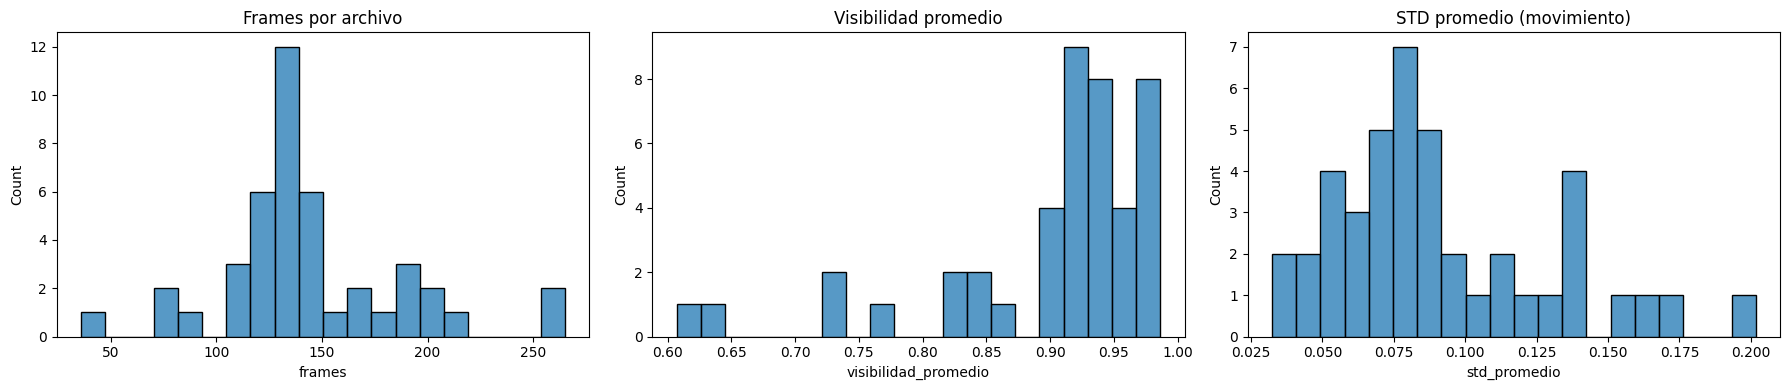

In [17]:
fig, axes = plt.subplots(1, 3, figsize=(18, 4))

sns.histplot(df_auditoria['frames'], bins=20, ax=axes[0])
axes[0].set_title('Frames por archivo')

sns.histplot(df_auditoria['visibilidad_promedio'], bins=20, ax=axes[1])
axes[1].set_title('Visibilidad promedio')

sns.histplot(df_auditoria['std_promedio'], bins=20, ax=axes[2])
axes[2].set_title('STD promedio (movimiento)')

plt.tight_layout()
plt.show()


In [18]:
def visualizar_pose(df, frame_idx=0, size=(5,7), title='Pose'):
    frame = df.iloc[frame_idx]
    x = [frame[f'x{i}'] for i in range(33)]
    y = [frame[f'y{i}'] for i in range(33)]
    plt.figure(figsize=size)
    plt.scatter(x, y, c='blue')
    plt.gca().invert_yaxis()
    for i, (xi, yi) in enumerate(zip(x, y)):
        plt.text(xi, yi, str(i), fontsize=7)
    plt.title(f'{title} - Frame {frame_idx}')
    plt.grid()
    plt.show()


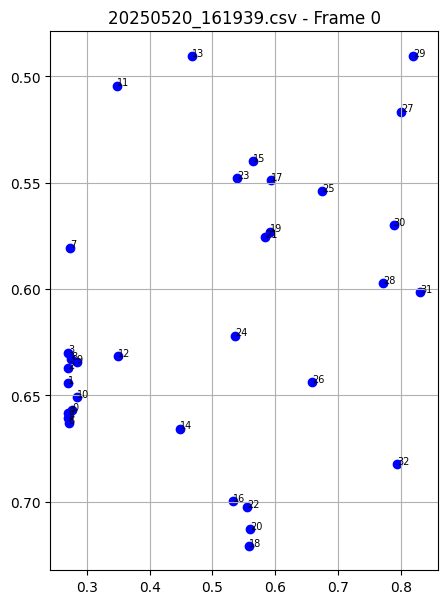

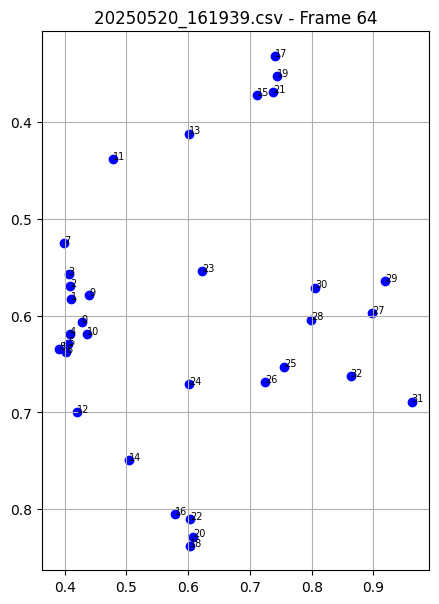

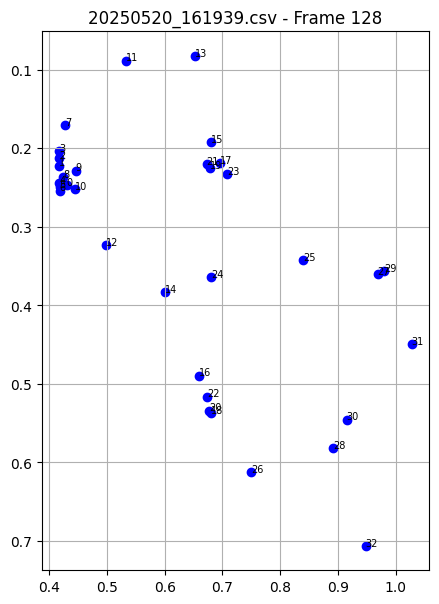

In [29]:
ejemplo = archivos[20]  # Cambia el índice para ver otros archivos
df_ejemplo = pd.read_csv(os.path.join(INPUT_DIR, ejemplo))

for i in [0, len(df_ejemplo)//2, len(df_ejemplo)-1]:
    visualizar_pose(df_ejemplo, i, title=ejemplo)


In [2]:
# 📦 Procesamiento en lote de todos los archivos .csv
def procesar_archivo(input_path, output_path, window=7):
    try:
        df = pd.read_csv(input_path)
        if df.empty or df.shape[0] < window:
            print(f"⚠️ Archivo muy corto o vacío: {os.path.basename(input_path)}")
            return False

        # Normalizar
        mid_x = (df['x23'] + df['x24']) / 2
        mid_y = (df['y23'] + df['y24']) / 2
        mid_z = (df['z23'] + df['z24']) / 2
        for i in range(33):
            df[f'x{i}'] -= mid_x
            df[f'y{i}'] -= mid_y
            df[f'z{i}'] -= mid_z

        # Suavizado
        for i in range(33):
            for axis in ['x', 'y', 'z']:
                col = f'{axis}{i}'
                if len(df) >= window:
                    df[col] = savgol_filter(df[col], window_length=window, polyorder=2)

        df.to_csv(output_path, index=False)
        print(f"✅ Procesado: {os.path.basename(output_path)}")
        return True

    except Exception as e:
        print(f"❌ Error procesando {os.path.basename(input_path)}: {e}")
        return False

# 📁 Crear carpeta de salida si no existe
os.makedirs(OUTPUT_DIR, exist_ok=True)

# 🧹 Procesar todos los archivos en lote
archivos = sorted(os.listdir(INPUT_DIR))
procesados = 0
for file in archivos:
    if file.endswith('.csv'):
        entrada = os.path.join(INPUT_DIR, file)
        salida = os.path.join(OUTPUT_DIR, file)
        if procesar_archivo(entrada, salida):
            procesados += 1

print(f"\n✅ Procesamiento completado. Archivos procesados: {procesados} / {len(archivos)}")


✅ Procesado: 20250520_161412.csv
✅ Procesado: 20250520_161425.csv
✅ Procesado: 20250520_161435.csv
✅ Procesado: 20250520_161443.csv
✅ Procesado: 20250520_161452.csv
✅ Procesado: 20250520_161503.csv
✅ Procesado: 20250520_161533.csv
✅ Procesado: 20250520_161543.csv
✅ Procesado: 20250520_161553.csv
✅ Procesado: 20250520_161605.csv
✅ Procesado: 20250520_161613.csv
✅ Procesado: 20250520_161631.csv
✅ Procesado: 20250520_161708.csv
✅ Procesado: 20250520_161724.csv
✅ Procesado: 20250520_161739.csv
✅ Procesado: 20250520_161750.csv
✅ Procesado: 20250520_161807.csv
✅ Procesado: 20250520_161827.csv
✅ Procesado: 20250520_161845.csv
✅ Procesado: 20250520_161856.csv
✅ Procesado: 20250520_161939.csv
✅ Procesado: 20250520_161951.csv
✅ Procesado: 20250520_162023.csv
✅ Procesado: 20250520_162042.csv
✅ Procesado: 20250520_162058.csv
✅ Procesado: 20250520_162112.csv
✅ Procesado: 20250520_162123.csv
✅ Procesado: 20250520_162141.csv
✅ Procesado: 20250520_162240.csv
✅ Procesado: 20250520_162249.csv
✅ Procesad

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

INPUT_DIR = 'data/processed_landmarks'
archivos = sorted([f for f in os.listdir(INPUT_DIR) if f.endswith('.csv')])

errores = []
estadisticas = []

for file in archivos:
    try:
        df = pd.read_csv(os.path.join(INPUT_DIR, file))

        if df.empty or df.shape[0] < 10:
            errores.append((file, 'muy pocos frames'))
            continue

        if df.isna().sum().sum() > 0:
            errores.append((file, 'NaN detectado'))
            continue

        stds = df.drop(columns='frame').std().mean()
        estadisticas.append({'archivo': file, 'frames': len(df), 'STD promedio': stds})

    except Exception as e:
        errores.append((file, str(e)))


✅ Todos los archivos están completos y sin errores graves.


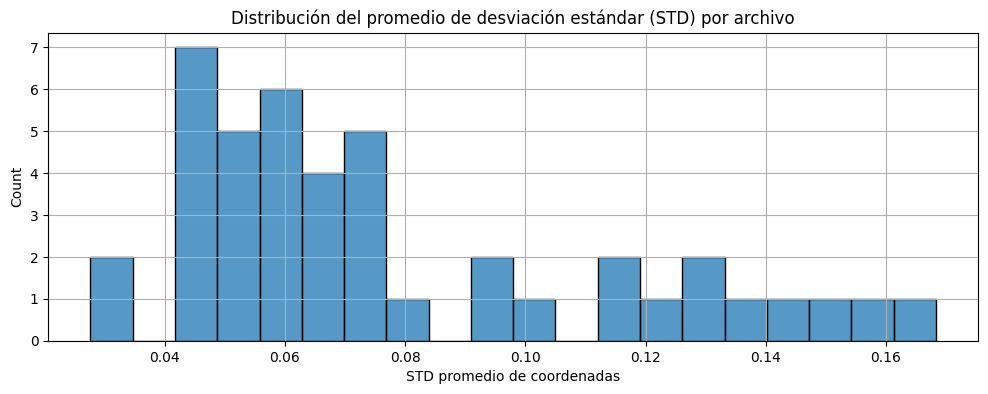

In [5]:
# Mostrar errores
if errores:
    print("⚠️ Archivos con problemas:")
    for nombre, causa in errores:
        print(f" - {nombre}: {causa}")
else:
    print("✅ Todos los archivos están completos y sin errores graves.")

# Mostrar resumen de estadísticas
df_stats = pd.DataFrame(estadisticas)
df_stats = df_stats.sort_values(by='STD promedio')

plt.figure(figsize=(12, 4))
sns.histplot(df_stats['STD promedio'], bins=20)
plt.title('Distribución del promedio de desviación estándar (STD) por archivo')
plt.xlabel('STD promedio de coordenadas')
plt.grid()
plt.show()


STD promedio entre ~0.04 y 0.08 en la mayoría de los archivos: Esto indica movimiento real, aunque moderado. Ideal para acciones suaves como sentarse, levantarse o caminar.

Cola derecha hasta ~0.16: Estos archivos probablemente contienen acciones más intensas o rápidas (por ejemplo, giros o transiciones rápidas).

Ningún archivo con STD < 0.01: No hay archivos con poses “planas” o detectadas erróneamente. 

Podemos continuar con confianza a extraer caracteristicas de estos archivos